In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

load_dotenv()

True

In [4]:
# Path to your service account key file
key_path = os.getenv("BIGQUERY_CREDENTIALS_PATH")

# Create credentials object
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

# Create client object
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

/home/aswerty123/miniconda3/envs/dsai_project/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


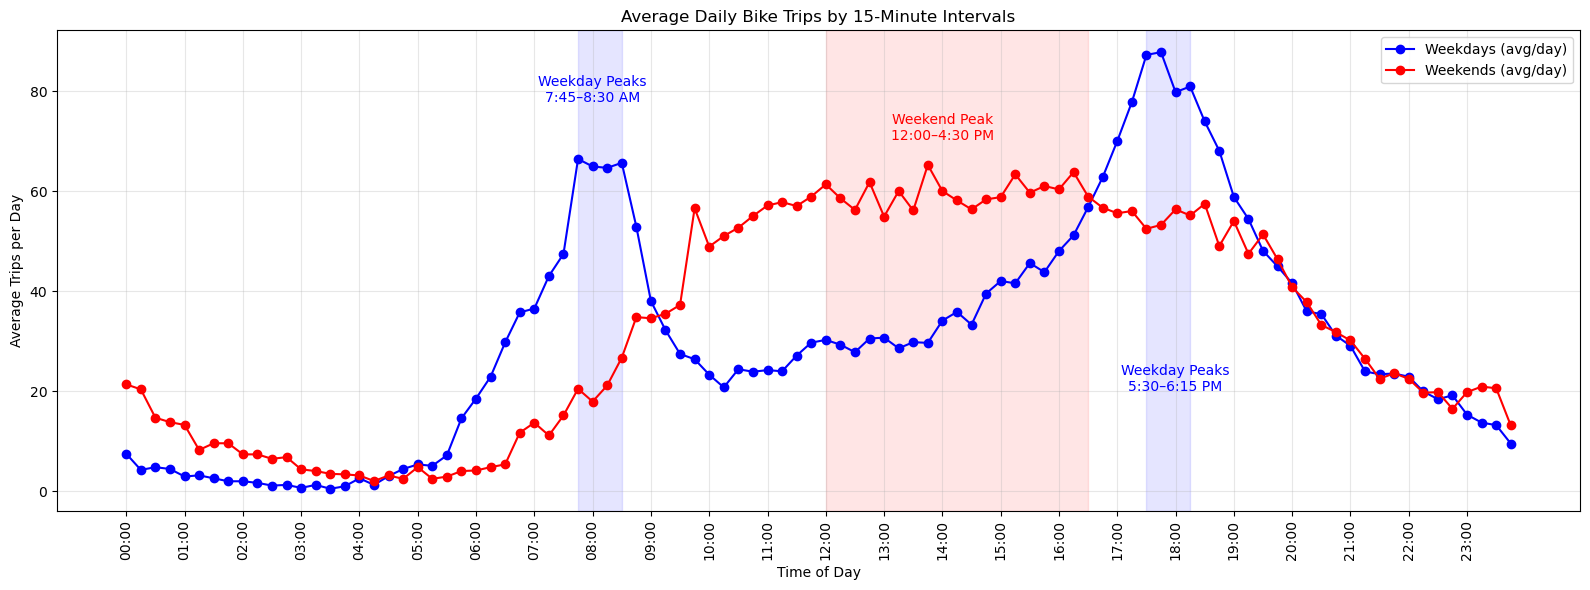

In [5]:
query = """
    SELECT
      DATE(started_at) AS date,
      CONCAT(
        LPAD(CAST(EXTRACT(HOUR FROM started_at) AS STRING), 2, '0'), ':',
        LPAD(CAST(FLOOR(EXTRACT(MINUTE FROM started_at)/15)*15 AS STRING), 2, '0')
      ) AS time_of_day,
      CASE
        WHEN EXTRACT(DAYOFWEEK FROM started_at) IN (1, 7) THEN 'weekend'
        ELSE 'weekday'
      END AS day_type
    FROM citibike_dbt.fact_trips ft
    WHERE started_at >= DATE_SUB(CURRENT_TIMESTAMP(), INTERVAL 50 DAY)
"""
trip_trend_df = client.query(query).to_dataframe()

# 1. Count trips per time slot per day
trip_counts = trip_trend_df.groupby(['date', 'time_of_day', 'day_type']).size().reset_index(name='trip_count')
# print(trip_counts)

# 2. Count number of unique days for each day_type
day_counts = trip_trend_df.groupby('day_type')['date'].nunique().reset_index(name='total_days')
# print(day_counts)

# 3. Calculate average trips per day
result = (
    trip_counts.groupby(['time_of_day', 'day_type'])['trip_count']
    .sum()
    .reset_index()
    .merge(day_counts, on='day_type')
)

result['avg_trips_per_day'] = result['trip_count'] / result['total_days']

# print(result)

# Pivot for plotting
pivot_df = result.pivot(index='time_of_day', columns='day_type', values='avg_trips_per_day')

# print(pivot_df)

# Define peak ranges (based on observed data)
weekday_peaks = [('07:45', '08:30'), ('17:30', '18:15')]
weekend_peaks = [('12:00', '16:30')]

# Convert to index positions for shading
def get_range_indices(start, end, index):
    return index.get_loc(start), index.get_loc(end)


# Visualization
plt.figure(figsize=(16, 6))
plt.plot(
    pivot_df.index,
    pivot_df['weekday'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Weekdays (avg/day)'
)
plt.plot(
    pivot_df.index,
    pivot_df['weekend'],
    marker='o',
    linestyle='-',
    color='red',
    label='Weekends (avg/day)'
)

plt.title('Average Daily Bike Trips by 15-Minute Intervals')
plt.xlabel('Time of Day')
plt.ylabel('Average Trips per Day')
# plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.legend()


# Shade weekday peaks
for start, end in weekday_peaks:
    i1, i2 = get_range_indices(start, end, pivot_df.index)
    plt.axvspan(i1, i2, color='blue', alpha=0.1)

# Shade weekend peaks
for start, end in weekend_peaks:
    i1, i2 = get_range_indices(start, end, pivot_df.index)
    plt.axvspan(i1, i2, color='red', alpha=0.1)

# Annotations
plt.text(pivot_df.index.get_loc('08:00'), pivot_df['weekday'].max() - 10,
         'Weekday Peaks\n7:45–8:30 AM',
         fontsize=10, color='blue', ha='center')

plt.text(pivot_df.index.get_loc('18:00'), 20,
         'Weekday Peaks\n5:30–6:15 PM',
         fontsize=10, color='blue', ha='center')

plt.text(pivot_df.index.get_loc('14:00'), pivot_df['weekend'].max() + 5,
         'Weekend Peak\n12:00–4:30 PM',
         fontsize=10, color='red', ha='center')

# Only show full hour labels on x-axis
hour_ticks = [t for t in pivot_df.index if t.endswith(':00')]
plt.xticks(ticks=[pivot_df.index.get_loc(t) for t in hour_ticks], labels=hour_ticks, rotation=90)




plt.tight_layout()
plt.show()

/home/aswerty123/miniconda3/envs/dsai_project/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

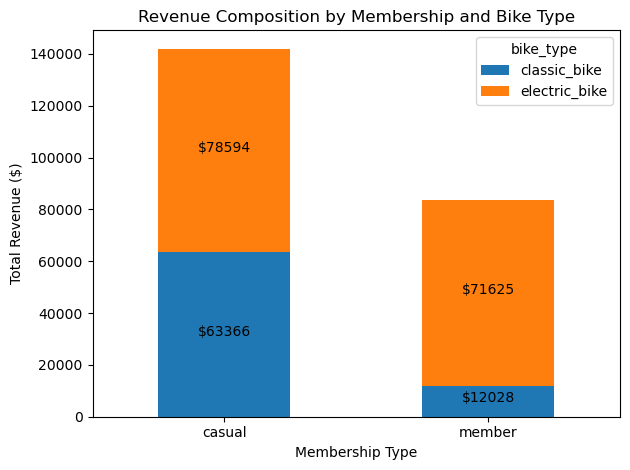

<Figure size 1000x600 with 0 Axes>

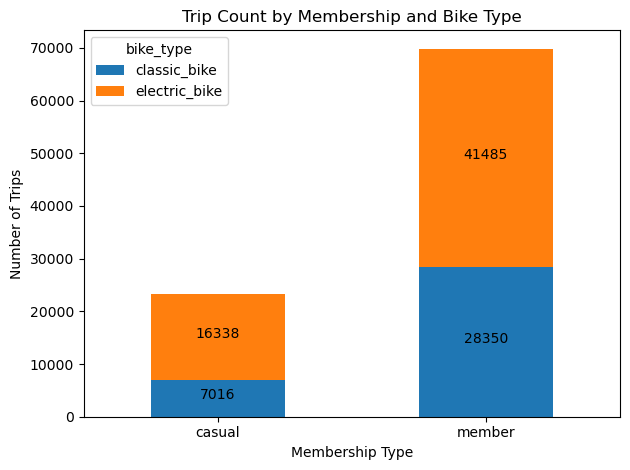

In [6]:
query = """
    SELECT
      DATE(started_at) AS date,
      dbt.type AS bike_type,
      dmt.type AS membership_type,
      price_paid,
      duration_mins
    FROM citibike_dbt.fact_trips ft
    JOIN citibike_dbt.dim_bike_types dbt ON ft.bike_type_id = dbt.bike_type_id
    JOIN citibike_dbt.dim_membership_types dmt ON ft.membership_type_id = dmt.membership_type_id
    WHERE started_at >= DATE_SUB(CURRENT_TIMESTAMP(), INTERVAL 50 DAY)
"""
trip_summary_df = client.query(query).to_dataframe()

# -----------------------
# Revenue composition chart
plt.figure(figsize=(10, 6))

# Calculate revenue by membership and bike type
rev_comp = trip_summary_df.groupby(['membership_type', 'bike_type'])['price_paid'].sum().unstack()

# Create stacked bar chart
rev_comp.plot(kind='bar', stacked=True, rot=0)

# Add chart labels and title
plt.title('Revenue Composition by Membership and Bike Type')
plt.ylabel('Total Revenue ($)')
plt.xlabel('Membership Type')

# Add value labels on top of each stack
for container in plt.gca().containers:
    plt.bar_label(container, label_type='center', fmt='$%.0f', padding=2)

plt.tight_layout()
plt.show()


# -----------------------
# Trip count composition chart
plt.figure(figsize=(10, 6))

# Group and unstack count
count_comp = trip_summary_df.groupby(['membership_type', 'bike_type']).size().unstack()

# Plot stacked bar for count
ax2 = count_comp.plot(kind='bar', stacked=True, rot=0)
plt.title('Trip Count by Membership and Bike Type')
plt.ylabel('Number of Trips')
plt.xlabel('Membership Type')

# Add value labels
for container in ax2.containers:
    ax2.bar_label(container, label_type='center', fmt='%.0f', padding=2)

plt.tight_layout()
plt.show()